# Load the data

Time step 1/5
Effective Sample Size (ESS): nan
Time step 2/5
Effective Sample Size (ESS): nan
Time step 3/5
Effective Sample Size (ESS): nan
Time step 4/5
Effective Sample Size (ESS): nan
Time step 5/5
Effective Sample Size (ESS): nan
Best Kernel Structure:
SE
Best Kernel Parameters:
{'SE': {'lengthscale': 2.999482433164301, 'variance': 2.164918825008921}}


c:\Users\taylo\Documents\Work\study\test\AutoGPy\example\..\main\Gauss.py:174: RuntimeWarning: invalid value encountered in scalar divide
  self.weights = [w / total_weight for w in self.weights]


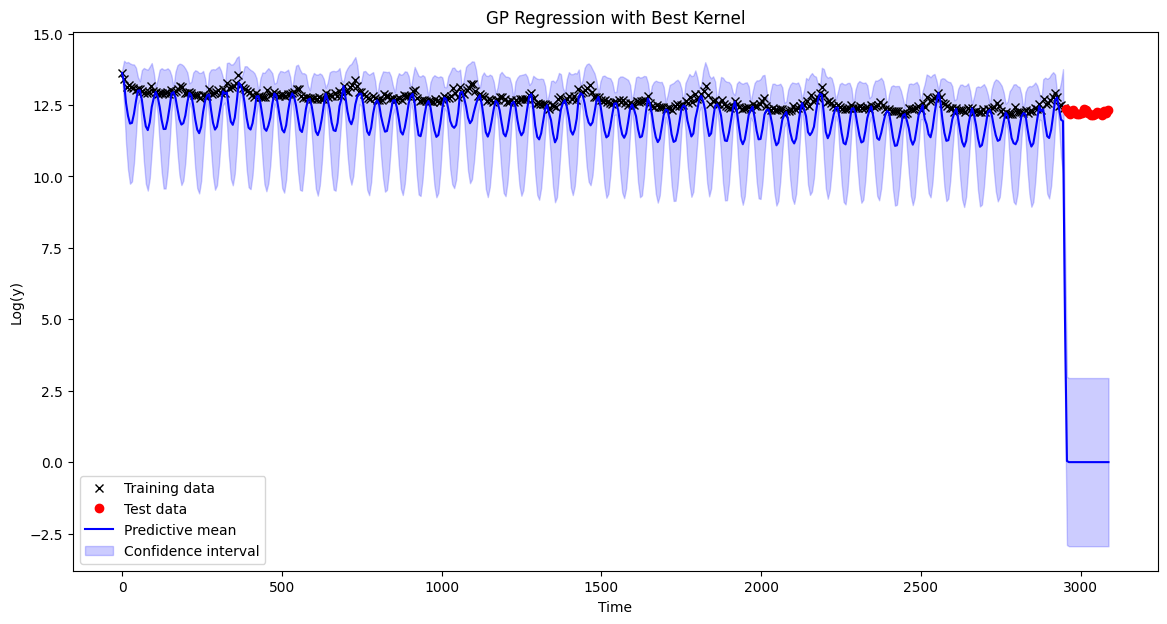

Test MSE: 148.8860


In [7]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
from main.AutoGPy import partition_data, SMCStructureLearning, plot_results_with_test, compute_gp_posterior
from sklearn.metrics import mean_squared_error

df = pd.read_csv("../data/iclaims.csv", header=0, names=["ds", "y"], parse_dates=["ds"])
df["y"] = np.log(df["y"])
df["t"] = (df["ds"] - df["ds"].min()).dt.days
x = df["t"].values
y = df["y"].values


# Split data into training and test sets
split_index = -20  # Last 20 time periods
x_train = x[:split_index]
y_train = y[:split_index]
x_test = x[split_index:]
y_test = y[split_index:]

# Partition training data
data_sequence = partition_data(x_train, y_train, num_partitions=5)

# Initialize SMC
smc = SMCStructureLearning(
    num_particles=8, num_rejuvenation_steps=3, max_kernel_depth=4
)

# Run SMC on training data
smc.run_smc(data_sequence)

# Collect particles and weights
particles = smc.particles
weights = smc.weights

# Find the particle with the highest weight
best_particle = particles[np.argmax(weights)]

print("Best Kernel Structure:")
print(best_particle.kernel)
print("Best Kernel Parameters:")
print(best_particle.kernel.get_params())

# Assign best_kernel
best_kernel = best_particle.kernel

# Plot the results with training and test data
plot_results_with_test(x_train, y_train, x_test, y_test, best_kernel)

# Evaluate on test data
mu_test, std_test = compute_gp_posterior(best_kernel, x_train, y_train, x_test)

# Compute MSE on test data
mse_test = mean_squared_error(y_test, mu_test)

print(f"Test MSE: {mse_test:.4f}")